<h1>BERT Text-Classification of SocialMedia posts about Fairdata<h1>

<h2>Imports / External Libraries<h2>

In [5]:
import pandas as pd
import re
import os
import torch
import torch.nn as nn
import numpy as np
import shutil
import sys   
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from torch.utils.data import DataLoader
from sklearn import metrics
from transformers import BertModel
from transformers import BertTokenizer
from torch.utils.data import Dataset
from langdetect import detect

<h2>Daten einlesen<h2>

In [6]:
path='../data'
df_manuell = pd.read_excel('../data/manuell_kategorisiert/pyhon_tweets_fairdata_Kategorisierung_ManuellExcel.xlsx')
df_manuell.columns = ['Data', 'ID', 'Content', 'Kategorisierung', 'Username', 'LikeCount', 'RetweetCount']

In [7]:
df_manuell.head(10)

,Data,ID,Content,Kategorisierung,Username,LikeCount,RetweetCount
0,Data,ID,Content,Kategorisierung,Username,LikeCount,RetweetCount
1,2023-03-28 10:54:07+00:00,1640668586736795649,@wilhwid @BBMRIERIC @ilireh @ECRIN_ERIC @tugra...,Meinung,eoscassociation,0,1
2,2023-03-28 10:52:12+00:00,1640668101200027648,I spent this morning with @EeroRinne and the s...,Veranstaltung,LukeDataManager,0,0
3,2023-03-28 10:37:03+00:00,1640664290452447237,The first panel at today's #EOSCTripartite eve...,Veranstaltung,eoscassociation,6,2
4,2023-03-28 10:00:53+00:00,1640655186694643712,💰That's right! We will provide financial suppo...,Initiative,fairimpact_eu,7,7
5,2023-03-28 09:48:14+00:00,1640652006120386560,The first main recommendation from the studyin...,"Veranstaltung, Publikation",Janete_Estevao,2,1
6,2023-03-28 08:09:00+00:00,1640627030982115329,"✨Today: Free @MetaCell webinar!✨\n\n📅 Mar 28, ...",Veranstaltung,INCForg,1,0
7,2023-03-28 07:55:57+00:00,1640623747739598849,Come and visit us and #DAPHNE4NFDI at our boot...,Veranstaltung,FAIRmat_NFDI,4,0
8,2023-03-28 07:55:51+00:00,1640623721592258561,#EOSC is an overarching system that supports r...,Publikation,eoscassociation,1,0
9,2023-03-28 07:55:49+00:00,1640623716253024256,EOSC Steering Board for Italy Giorgio Rossi pr...,Veranstaltung,eoscassociation,2,0


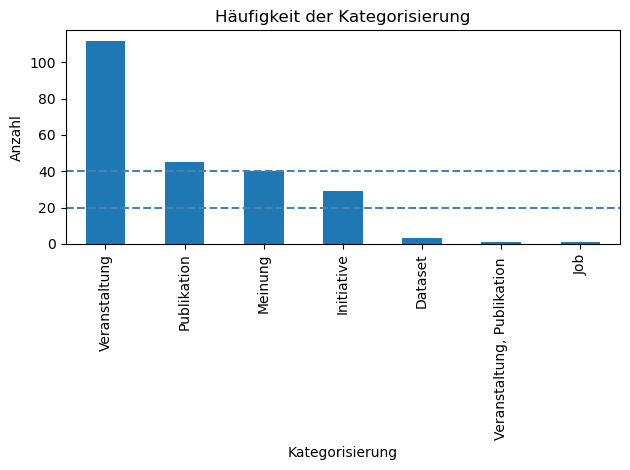

In [8]:
df_manuell = df_manuell[1:]  # Überspringen Sie die erste Zeile, die Spaltennamen enthält
df_manuell['Kategorisierung'] = df_manuell['Kategorisierung'].replace('Meinung ', 'Meinung')

category_counts = df_manuell['Kategorisierung'].value_counts()

category_counts.plot(kind='bar')
plt.xlabel('Kategorisierung')
plt.ylabel('Anzahl')
plt.title('Häufigkeit der Kategorisierung')
plt.axhline(y=20, color='steelblue', linestyle='--')  # Draw a dashed red line at y=20
plt.axhline(y=40, color='steelblue', linestyle='--')  # Draw a dashed green line at y=40
plt.tight_layout()
plt.savefig('../results/kategorisierung_plot.png', dpi=1000)
plt.show()


Die bereits manuell kategorisierten Tweets im DF speichern

In [9]:
df1 = df_manuell.iloc[1:]
df1 = df1[df1['Kategorisierung'].notna()]
df1.head()

,Data,ID,Content,Kategorisierung,Username,LikeCount,RetweetCount
2,2023-03-28 10:52:12+00:00,1640668101200027648,I spent this morning with @EeroRinne and the s...,Veranstaltung,LukeDataManager,0,0
3,2023-03-28 10:37:03+00:00,1640664290452447237,The first panel at today's #EOSCTripartite eve...,Veranstaltung,eoscassociation,6,2
4,2023-03-28 10:00:53+00:00,1640655186694643712,💰That's right! We will provide financial suppo...,Initiative,fairimpact_eu,7,7
5,2023-03-28 09:48:14+00:00,1640652006120386560,The first main recommendation from the studyin...,"Veranstaltung, Publikation",Janete_Estevao,2,1
6,2023-03-28 08:09:00+00:00,1640627030982115329,"✨Today: Free @MetaCell webinar!✨\n\n📅 Mar 28, ...",Veranstaltung,INCForg,1,0


<h2>Preprocess<h2>

Mögliche Leerzeichen aus den Labels entfernen und Labels wie Dataset, Job, Initiative als Divers speichern

In [10]:
df1.loc[df1['Kategorisierung'] == 'Veranstaltung, Publikation ', 'Kategorisierung'] = 'Veranstaltung'
df1['Kategorisierung'] = df1['Kategorisierung'].replace('Meinung ', 'Meinung')
df1.loc[df1['Kategorisierung'] == 'Dataset', 'Kategorisierung'] = 'Divers'
df1.loc[df1['Kategorisierung'] == 'Job', 'Kategorisierung'] = 'Divers'
df1.loc[df1['Kategorisierung'] == 'Initiative', 'Kategorisierung'] = 'Divers'

df1 = df1[df1['Kategorisierung'] != 'Divers']

In [11]:
df1.head()
df1.shape

(197, 7)

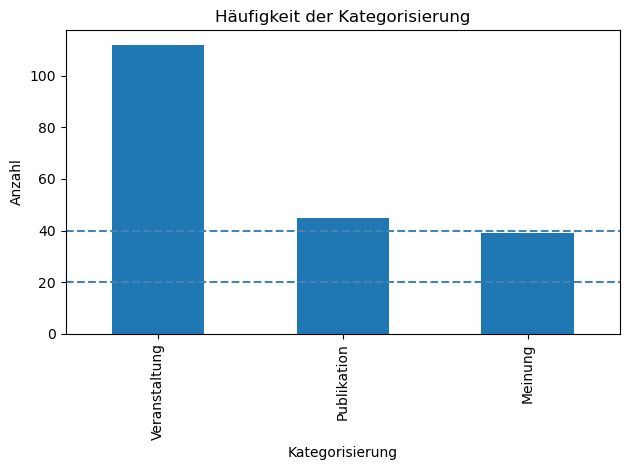

In [12]:
df1 = df1[1:]  # Überspringen Sie die erste Zeile, die Spaltennamen enthält

category_counts = df1['Kategorisierung'].value_counts()

category_counts.plot(kind='bar')
plt.xlabel('Kategorisierung')
plt.ylabel('Anzahl')
plt.title('Häufigkeit der Kategorisierung')
plt.axhline(y=20, color='steelblue', linestyle='--')  # Draw a dashed red line at y=20
plt.axhline(y=40, color='steelblue', linestyle='--')  # Draw a dashed green line at y=40
plt.tight_layout()
plt.savefig('../results/kategorisierung_plot_divers.png', dpi=1000)
plt.show()

<h2>preprocess text funciton <h2>

In [13]:
#%load_ext
#%autoreload 2
def pre_process(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

## Filter out non English posts

In [14]:
def filter_non_english_tweets(dataframe, lang='en'):
    filtered_df = dataframe[dataframe['Clean_Content'].apply(lambda x: detect(x) == lang)]
    return filtered_df

<h2>Text Preprocessing auf DF anwenden<h2>

In [15]:
df1['Clean_Content'] = df1['Content'].apply(pre_process)
df1.shape

print("Content before Preprocessing:")
print("")
print(df1.loc[10, 'Content'])
print("Content after Preprocessing:")
print(" ")
print(df1.loc[10, 'Clean_Content'])


Content before Preprocessing:

Workshop, ‘The WorldFAIR Project’s cross-domain interoperability framework’, 20 March: slides and recording now available
https://t.co/DFBr1YNLVh
#codata #FAIRdata #OpenScience #datascience #opendata https://t.co/DSOhKfCZgh
Content after Preprocessing:
 
workshop the worldfair project s cross domain interoperability framework march slides and recording now available https t co dfbr ynlvh codata fairdata openscience datascience opendata https t co dsohkfczgh


/Users/nelesassor/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [16]:
print("Content before Preprocessing:")
print("")
print(df1.loc[11, 'Content'])
print("")
print("Content after Preprocessing:")
print(" ")
print(df1.loc[11, 'Clean_Content'])

Content before Preprocessing:

#NewSpecies!
New bush-cricket from Brazil just crawled in:

Listroscelis cyanotibiatus

Treatment: https://t.co/8QMYD7hAZW
Publication: https://t.co/E7PUoLxNhU
@Zootaxa @insect_otd @CSE_at_FSCA @RoyEntSoc @OrthopteraCH

#FAIRdata #nature #Biodiversity #conservation #entomology https://t.co/oPNZ1Oy8hW

Content after Preprocessing:
 
newspecies new bush cricket from brazil just crawled in listroscelis cyanotibiatus treatment https t co qmyd hazw publication https t co e puolxnhu zootaxa insect otd cse at fsca royentsoc orthopterach fairdata nature biodiversity conservation entomology https t co opnz oy hw


In [18]:
df1 = filter_non_english_tweets(df1, lang='en')
df1.shape

(181, 8)

Merge Kategorisierung und Content into one dataframe

In [19]:

newdf = df1.loc[:,['Clean_Content','Kategorisierung']]

test_dataset = newdf[170:]
test_dataset.head()

,Clean_Content,Kategorisierung
220,the agentproject train the trainer team teache...,Veranstaltung
221,just published emily rayfield pamela gill laut...,Publikation
222,just published controlled rachael gooberman hi...,Publikation
223,the cicompass fair findable accessible interop...,Meinung
224,a short video about our brand new dataset sear...,Meinung


Einteilen in x und y und DF verkleinern und restlichen Beispiele für Testing und Validierung verwenden

In [20]:
y = newdf['Kategorisierung']
x = newdf['Clean_Content']

newdf = newdf[:170]
newdf.shape

(170, 2)

In [21]:
len(newdf['Kategorisierung'].unique())

test_dataset.head()

,Clean_Content,Kategorisierung
220,the agentproject train the trainer team teache...,Veranstaltung
221,just published emily rayfield pamela gill laut...,Publikation
222,just published controlled rachael gooberman hi...,Publikation
223,the cicompass fair findable accessible interop...,Meinung
224,a short video about our brand new dataset sear...,Meinung


In [22]:
target_list = ['Meinung','Publikation', 'Veranstaltung']

<h2>One Hot Encodign der Labels <h2>

In [23]:
# Führe One-Hot-Encoding durch
one_hot_encoded = pd.get_dummies(newdf['Kategorisierung'])


In [24]:
ohe_df = pd.concat([newdf, one_hot_encoded], axis=1)


In [25]:
ohe_df = ohe_df.drop('Kategorisierung', axis=1)
ohe_df.head()


,Clean_Content,Meinung,Publikation,Veranstaltung
3,the first panel at today s eosctripartite even...,0,0,1
5,the first main recommendation from the studyin...,0,0,1
6,today free metacell webinar mar pm edt for res...,0,0,1
7,come and visit us and daphne nfdi at our booth...,0,0,1
8,eosc is an overarching system that supports re...,0,1,0


In [26]:
ohe_df['Label'] = ohe_df[['Meinung', 'Publikation', 'Veranstaltung']].values.tolist()
ohe_df = ohe_df.drop(columns = ['Meinung', 'Publikation', 'Veranstaltung'])
ohe_df.head(5)

,Clean_Content,Label
3,the first panel at today s eosctripartite even...,"[0, 0, 1]"
5,the first main recommendation from the studyin...,"[0, 0, 1]"
6,today free metacell webinar mar pm edt for res...,"[0, 0, 1]"
7,come and visit us and daphne nfdi at our booth...,"[0, 0, 1]"
8,eosc is an overarching system that supports re...,"[0, 1, 0]"


Preproccing Funktion um Symbole aus dem Text zu entfernen

In [27]:
def cleaning_text(text):
    text = text.lower()
    text = re.sub('r<.*?>', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'http\S+', " ", text)

    text = text.split()
    stop_words = stopwords.words("english")
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")

    return text

ohe_df['Clean_Content'] = ohe_df['Clean_Content'].apply(lambda x: cleaning_text(x))

ohe_df.head()


,Clean_Content,Label
3,first panel today eosctripartite event bulgari...,"[0, 0, 1]"
5,first main recommendation studying scientific ...,"[0, 0, 1]"
6,today free metacell webinar mar pm edt researc...,"[0, 0, 1]"
7,come visit us daphne nfdi booth today tomorrow...,"[0, 0, 1]"
8,eosc overarching system supports research inno...,"[0, 1, 0]"


<h2>Bert Model<h2>

In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [29]:
max_len = 32
# Class PrepDataset to format the dataset to feed the BERT model
class PrepDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Clean_Content']
      #  self.targets = dataframe['Label']
        self.targets = self.data.Label
        self.max_len = max_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }
     

In [30]:
#Split 8:2 ratio train-validation
train_size = 0.8
train_dataset = ohe_df.sample(frac=train_size,random_state=200)
valid_dataset = ohe_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
training_set = PrepDataset(train_dataset, tokenizer, max_len)
validation_set = PrepDataset(valid_dataset, tokenizer, max_len)
training_loader = DataLoader(training_set, batch_size=30)
validation_loader = DataLoader(validation_set, batch_size=30)

In [31]:
# BERT model class
class BERT(torch.nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 3)
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [32]:
print(torch.__version__)

1.12.1


In [33]:
device = torch.device("cpu")

In [34]:
# Training
epochs = 4
learning_rate = 0.0001
model = BERT()
model.to(device)
len_trainloader = len(training_loader)
loss_f = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
train_loss = 0
valid_loss = 0
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
for epoch in range(epochs):
  avg_loss = 0
  items = 0
  for batch_idx, data in enumerate(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
  print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

file_path = '/Users/nelesassor/Desktop/TwitterAnalyse/src/Model/model.pth'

torch.save(model.state_dict(), file_path)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0, Training Loss:  0.6112890839576721
Epoch: 1, Training Loss:  0.47920823097229004
Epoch: 2, Training Loss:  0.4284406006336212
Epoch: 3, Training Loss:  0.2829594612121582


In [35]:
val_targets=[]
val_outputs=[]
valid_loss=0     

In [36]:
# Validation

model.eval()
with torch.no_grad():
    for batch_idx, data in enumerate(validation_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
        val_targets.extend(targets.cpu().detach().numpy().tolist())
        val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
     

In [37]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1 = metrics.f1_score(val_targets, val_preds, average='micro')

In [38]:
# Accuracy and F1 score of the model
print("Accuracy: " +str(accuracy))
print("F1 Score: " +str(f1))

Accuracy: 0.7352941176470589
F1 Score: 0.7647058823529412


In [39]:
# Prepare the prediction dataset for the model for the test
class PredictionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Clean_Content']
        self.max_len = max_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        }

In [40]:
# Function to use the model with the test dataset
def do_prediction(loader):
    model.eval()
    pred_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            pred_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return pred_outputs
     

In [41]:
test_set = PredictionDataset(valid_dataset, tokenizer, max_len)
testing_loader = DataLoader(test_set, batch_size=10)

In [42]:
test_dataset.head()

,Clean_Content,Kategorisierung
220,the agentproject train the trainer team teache...,Veranstaltung
221,just published emily rayfield pamela gill laut...,Publikation
222,just published controlled rachael gooberman hi...,Publikation
223,the cicompass fair findable accessible interop...,Meinung
224,a short video about our brand new dataset sear...,Meinung


Trainings und Testdaten trennen

In [43]:
target_list = ['Meinung', 'Publikation', 'Veranstaltung', 'Divers']
# Test data preprocessing 
test_dataset['Clean_Content'] = test_dataset['Clean_Content'].apply(lambda x: cleaning_text(x))
test_actual = pd.get_dummies(test_dataset['Kategorisierung'])
test_actual['Label'] = test_actual[['Meinung','Publikation', 'Veranstaltung']].values.tolist()
test_actual = test_actual.drop(columns = ['Meinung', 'Publikation', 'Veranstaltung'])
test_dataset = test_dataset.drop(columns = ['Kategorisierung'])
test_dataset = test_dataset.reset_index(drop=True)
test_set = PredictionDataset(test_dataset, tokenizer, max_len)
testing_loader = DataLoader(test_set, batch_size=30)

In [44]:
# Concatenate the predictions with the test dataset
pred_outputs = do_prediction(testing_loader)
pred_outputs = (np.array(pred_outputs) >= 0.5).astype(int)
preds_df = pd.DataFrame(pred_outputs, columns =['Meinung', 'Publikation', 'Veranstaltung'])
df_concat = pd.concat([test_dataset, preds_df], axis=1)

print(preds_df)

    Meinung  Publikation  Veranstaltung
0         0            0              1
1         0            1              0
2         0            1              0
3         0            0              1
4         0            0              1
5         0            0              1
6         0            1              0
7         0            0              1
8         0            0              1
9         0            0              1
10        0            0              1


In [45]:
# Accuracy of predicted test data vs actual test data
actual = test_actual['Label'].tolist()
accuracy_test = metrics.accuracy_score(actual, pred_outputs)
print(actual)
actual = np.array(actual)
pred_outputs = np.array(pred_outputs)


actual_idx = np.argmax(actual, axis=1)


actual_labels = [target_list[idx] for idx in actual_idx]


# Print actual_labels and accuracy_test
print(actual_labels)
print(accuracy_test)


[[0, 0, 1], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 0, 1], [0, 0, 1]]
['Veranstaltung', 'Publikation', 'Publikation', 'Meinung', 'Meinung', 'Meinung', 'Publikation', 'Veranstaltung', 'Meinung', 'Veranstaltung', 'Veranstaltung']
0.6363636363636364


In [46]:
result = pd.concat([test_dataset['Clean_Content'], preds_df], axis=1)

print(result)

                                        Clean_Content  Meinung  Publikation  \
0   agentproject train trainer team teached traine...        0            0   
1   published emily rayfield pamela gill lautensch...        0            1   
2   published controlled rachael gooberman hill an...        0            1   
3   cicompass fair findable accessible interoperab...        0            0   
4   short video brand new dataset search look subs...        0            0   
5   great assistant prof position fair research da...        0            0   
6   newspecies new squat lobster pacific ocean flu...        0            1   
7   excited joining data spaces symposium come vis...        0            0   
8   encouraged intellectual assets managed way ena...        0            0   
9   iwd ilarosat martinapulieri cristinadimuri fol...        0            0   
10  watch demand experts sharing experiences explo...        0            0   

    Veranstaltung  
0               1  
1          

In [47]:
df_concat_string = result.to_string(header=False, index=False, index_names=False, justify='left', col_space=1, max_colwidth=None)

result_good = pd.concat([test_dataset['Clean_Content'], pd.Series(actual_labels)], axis=1)
pd.reset_option('all')
print(result_good)
print(result_good.shape)

                                        Clean_Content              0
0   agentproject train trainer team teached traine...  Veranstaltung
1   published emily rayfield pamela gill lautensch...    Publikation
2   published controlled rachael gooberman hill an...    Publikation
3   cicompass fair findable accessible interoperab...        Meinung
4   short video brand new dataset search look subs...        Meinung
5   great assistant prof position fair research da...        Meinung
6   newspecies new squat lobster pacific ocean flu...    Publikation
7   excited joining data spaces symposium come vis...  Veranstaltung
8   encouraged intellectual assets managed way ena...        Meinung
9   iwd ilarosat martinapulieri cristinadimuri fol...  Veranstaltung
10  watch demand experts sharing experiences explo...  Veranstaltung
(11, 2)


/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_35922/2698595595.py:4: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_35922/2698595595.py:4: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_35922/2698595595.py:4: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')


In [48]:
accuracy_test

0.6363636363636364

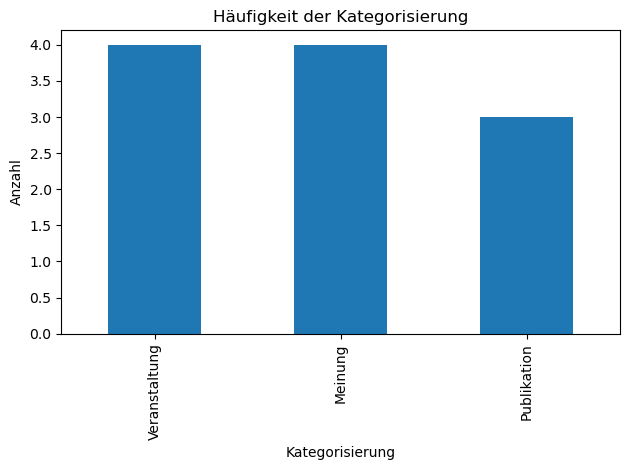

Veranstaltung    4
Meinung          4
Publikation      3
Name: Kategorisierung, dtype: int64


In [49]:

result_good.columns = ['Content','Kategorisierung']
#result_good = result_good[1:]  # Überspringen Sie die erste Zeile, die Spaltennamen enthält

category_counts = result_good['Kategorisierung'].value_counts()

category_counts.plot(kind='bar')
plt.xlabel('Kategorisierung')
plt.ylabel('Anzahl')
plt.title('Häufigkeit der Kategorisierung')
plt.tight_layout()
plt.savefig('../results/kategorisierung_plot.png', dpi=500)
plt.show()

print(category_counts)

<h2>Apply the model on the rest of the dataframe<h2>

In [50]:
#auf python_tweets_fairdata.csv anwenden

In [51]:
df_fairdata = pd.read_csv('../data/twitter/pyhon_tweets_fairdata.csv')

In [52]:
newdf_fairdata = df_fairdata.loc[:,['Content']]

In [53]:
newdf_fairdata['Clean_Content'] = newdf_fairdata['Content'].apply(pre_process)
newdf_fairdata.shape

/Users/nelesassor/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


(1002, 2)

In [54]:
newdf_fairdata = filter_non_english_tweets(newdf_fairdata, lang='en')
newdf_fairdata.shape

(918, 2)

In [55]:
bert = newdf_fairdata.loc[:,['Clean_Content']]

In [56]:
print(bert.head(10))

                                       Clean_Content
0  wilhwid bbmrieric ilireh ecrin eric tugraz gat...
1  i spent this morning with eerorinne and the st...
2  the first panel at today s eosctripartite even...
3  that s right we will provide financial support...
4  the first main recommendation from the studyin...
5  today free metacell webinar mar pm edt for res...
6  come and visit us and daphne nfdi at our booth...
7  eosc is an overarching system that supports re...
8  eosc steering board for italy giorgio rossi pr...
9  workshop the worldfair project s cross domain ...


In [57]:
test_dataset = bert.reset_index(drop=True)
test_set = PredictionDataset(test_dataset, tokenizer, max_len)
testing_loader = DataLoader(test_set, batch_size=100)

In [59]:

# Concatenate the predictions with the test dataset
pred_outputs = do_prediction(testing_loader)
pred_outputs = (np.array(pred_outputs) >= 0.5).astype(int)
preds_df = pd.DataFrame(pred_outputs, columns =['Meinung', 'Publikation', 'Veranstaltung'])
df_concat = pd.concat([bert, preds_df], axis=1)

print(preds_df)

     Meinung  Publikation  Veranstaltung
0          0            0              1
1          0            0              1
2          0            0              1
3          0            0              1
4          0            0              1
..       ...          ...            ...
913        0            1              0
914        0            1              0
915        0            0              1
916        0            0              1
917        0            0              1

[918 rows x 3 columns]


In [60]:
result = pd.concat([test_dataset['Clean_Content'], preds_df], axis=1)

print(result)

                                         Clean_Content  Meinung  Publikation  \
0    wilhwid bbmrieric ilireh ecrin eric tugraz gat...        0            0   
1    i spent this morning with eerorinne and the st...        0            0   
2    the first panel at today s eosctripartite even...        0            0   
3    that s right we will provide financial support...        0            0   
4    the first main recommendation from the studyin...        0            0   
..                                                 ...      ...          ...   
913  merry fishmas newspecies new sisorid catfish f...        0            1   
914  newspecies new burrowing toad from brazil just...        0            1   
915  do you have a story to tell about your opensci...        0            0   
916  very happy to initiate the inchi revival in aa...        0            0   
917  closing phd opportunity at uniofoxford oxforde...        0            0   

     Veranstaltung  
0                1

In [61]:
actual = np.array(preds_df)
actual_idx = np.argmax(actual, axis=1)
target_list = ['Meinung','Publikation', 'Veranstaltung']

actual_labels = [target_list[idx] for idx in actual_idx]

In [62]:
result = pd.concat([test_dataset['Clean_Content'], preds_df], axis=1)

df_concat_string = result.to_string(header=False, index=False, index_names=False, justify='left', col_space=1, max_colwidth=None)

result_good = pd.concat([test_dataset['Clean_Content'], pd.Series(actual_labels)], axis=1)
print(result_good)

                                         Clean_Content              0
0    wilhwid bbmrieric ilireh ecrin eric tugraz gat...  Veranstaltung
1    i spent this morning with eerorinne and the st...  Veranstaltung
2    the first panel at today s eosctripartite even...  Veranstaltung
3    that s right we will provide financial support...  Veranstaltung
4    the first main recommendation from the studyin...  Veranstaltung
..                                                 ...            ...
913  merry fishmas newspecies new sisorid catfish f...    Publikation
914  newspecies new burrowing toad from brazil just...    Publikation
915  do you have a story to tell about your opensci...  Veranstaltung
916  very happy to initiate the inchi revival in aa...  Veranstaltung
917  closing phd opportunity at uniofoxford oxforde...  Veranstaltung

[918 rows x 2 columns]


In [152]:
result_good.to_csv('../results/tweets_labeled_English_only.csv', index=False)

In [ ]:

result_good.columns = ['Content','Kategorisierung']
#result_good = result_good[1:]  # Überspringen Sie die erste Zeile, die Spaltennamen enthält

category_counts = result_good['Kategorisierung'].value_counts()

category_counts.plot(kind='bar')
plt.xlabel('Kategorisierung')
plt.ylabel('Anzahl')
plt.title('Häufigkeit der Kategorisierung')
plt.tight_layout()
plt.savefig('../results/kategorisierung_plot_Tweets.png', dpi=1000)
plt.show()

print(category_counts)

## Apply Model to another Datset from Mastodon
python_mastodonScienceCom_toots_fairdata.csv


In [64]:
import analysis


In [151]:
df_fairdata = pd.read_csv('../data/mastodon/alt/python_mastodonScienceCom_toots_fairdata.csv')

In [104]:
df = analysis.df
print(df.columns)

Index(['Unnamed: 0', 'id', 'created_at', 'in_reply_to_id',
       'in_reply_to_account_id', 'sensitive', 'spoiler_text', 'visibility',
       'language', 'uri', 'url', 'replies_count', 'reblogs_count',
       'favourites_count', 'edited_at', 'content', 'reblog', 'account',
       'media_attachments', 'mentions', 'tags', 'emojis', 'card', 'poll',
       'application', 'limited', 'local_only', 'content_type', 'quote'],
      dtype='object')


In [105]:
#newdf_fairdata = df_fairdata.loc[:,['content']]
df_new = df.loc[:,['content']]

In [106]:
df_new['Clean_Content'] = df_new['content'].apply(pre_process)
df_new.shape

(7590, 2)

In [107]:
df_new = filter_non_english_tweets(df_new, lang='en')
df_new.shape

(7160, 2)

In [108]:
bert = df_new.loc[:,['Clean_Content']]

In [109]:
print(bert.head(10))

                                                                                           Clean_Content
../data/mastodon/python_tooswales_toots_fairdat... 0   publish your data with confidence our data pub...
                                                   1   newspeciesnew jumping spider from china just j...
                                                   2   newspecies new freshwater mussel from north ca...
                                                   3   learn about fair principled stewardship of mac...
                                                   4   on june th danielvanstrien machine learning li...
                                                   5   newspecies new frog from australia just hopped...
                                                   6   newspecies new robber fly from mozambique just...
                                                   8   newspecies parodia hofackerianaa newly discove...
                                                   9   

In [110]:
test_dataset = bert.reset_index(drop=True)
test_set = PredictionDataset(test_dataset, tokenizer, max_len)
testing_loader = DataLoader(test_set, batch_size=100)

In [ ]:
# Concatenate the predictions with the test dataset
pred_outputs = do_prediction(testing_loader)
pred_outputs = (np.array(pred_outputs) >= 0.5).astype(int)
preds_df = pd.DataFrame(pred_outputs, columns =['Meinung', 'Publikation', 'Veranstaltung'])
#bert.index = bert.index.to_flat_index()
#df_concat = pd.concat([bert, preds_df], axis=1)


saved_index = bert.index
bert = bert.reset_index(drop=True)
preds_df = preds_df.reset_index(drop=True)
df_concat = pd.concat([bert, preds_df], axis=1)
df_concat.index = saved_index

In [ ]:
df_concat.shape

In [111]:
df_new_reset = df_new.reset_index(drop=True)
preds_df_reset = preds_df.reset_index(drop=True)

result2 = pd.concat([df_new_reset, preds_df_reset], axis=1)

                                                content  \
0     <p>Publish your data with confidence! </p><p>O...   
1     <p><a href="https://mastodon.green/tags/NewSpe...   
2     <p><a href="https://mastodon.green/tags/NewSpe...   
3     <p>Learn about FAIR-principled stewardship of ...   
4     <p>On June 26th, <span class="h-card"><a href=...   
...                                                 ...   
7155  <p>My <a href="https://scholar.social/tags/int...   
7156  <p>Alright found a better home! Here's another...   
7157  <p>At the <a href="https://mastodon.social/tag...   
7158  <p>My social media philosophy...<br>- 75% work...   
7159  <p>Hello <a href="https://berlin.social/tags/C...   

                                          Clean_Content  Meinung  Publikation  \
0     publish your data with confidence our data pub...      0.0          0.0   
1     newspeciesnew jumping spider from china just j...      0.0          1.0   
2     newspecies new freshwater mussel from nort

In [112]:
actual = np.array(preds_df)
actual_idx = np.argmax(actual, axis=1)
target_list = ['Meinung','Publikation', 'Veranstaltung']

actual_labels = [target_list[idx] for idx in actual_idx]

In [123]:
if df.index.duplicated().any():
    print("Duplikate im Index von df_new gefunden!")
    df = df.reset_index(drop=True)
    
    
if preds_df.index.duplicated().any():
    print("Duplikate im Index von preds_df gefunden!")
    preds_df = preds_df.reset_index(drop=True)

Duplikate im Index von df_new gefunden!


In [128]:
df.index = df.index.to_flat_index()
result2 = pd.concat([df, preds_df], axis=1)
df_concat_string = result2.to_string(header=False, index=False, index_names=False, justify='left', col_space=1, max_colwidth=None)
result_good = pd.concat([df, pd.Series(actual_labels)], axis=1)

result2.head(10)
result_good.shape
result_good = result_good.rename(columns={0: 'category'})
print(result_good.columns)


Index(['Unnamed: 0', 'id', 'created_at', 'in_reply_to_id',
       'in_reply_to_account_id', 'sensitive', 'spoiler_text', 'visibility',
       'language', 'uri', 'url', 'replies_count', 'reblogs_count',
       'favourites_count', 'edited_at', 'content', 'reblog', 'account',
       'media_attachments', 'mentions', 'tags', 'emojis', 'card', 'poll',
       'application', 'limited', 'local_only', 'content_type', 'quote',
       'category'],
      dtype='object')


In [157]:
# Erstellt einen neuen DataFrame mit nur den gewünschten Spalten
selected_columns = ['id', 'created_at', 'content', 'account', 'replies_count', 'reblogs_count', 
                    'favourites_count', 'language', 'mentions', 'tags', 'emojis', 'category']
filtered_df = result_good[selected_columns]

# Speichert den DataFrame als CSV-Datei
filtered_df.to_csv('../results/filtered_data.csv', index=False)

filtered_df.head()

KeyError: "['id', 'created_at', 'account', 'replies_count', 'reblogs_count', 'favourites_count', 'language', 'mentions', 'tags', 'emojis', 'category'] not in index"

In [131]:
duplicates = filtered_df.duplicated()

# Anzahl der Duplikate
num_duplicates = duplicates.sum()

print(f"Anzahl der Duplikate: {num_duplicates}")

Anzahl der Duplikate: 445


In [141]:
df_no_duplicates = filtered_df.drop_duplicates()
df_no_duplicates.shape

(7145, 12)

In [143]:
# Speichert den DataFrame als CSV-Datei
df_no_duplicates.to_csv('../results/categorized_toots.csv', index=False)

In [146]:
df_no_duplicates['content'] = df_no_duplicates['content'].apply(analysis.preprocess_text)

/var/folders/2s/fkmsmwt93ln3hc_sf08vff_m0000gn/T/ipykernel_35922/2632334103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_duplicates['content'] = df_no_duplicates['content'].apply(analysis.preprocess_text)


In [147]:
df_no_duplicates.to_csv('../results/categorized_toots_preprocessed.csv', index=False)


,id,created_at,content,account,replies_count,reblogs_count,favourites_count,language,mentions,tags,emojis,category
0,110548966831726201,2023-06-15T15:36:04.000Z,publish your data with confidence our data pub...,"{'id': '109342933770338406', 'username': 'epim...",0,0,0,en,[],"[{'name': 'fairdata', 'url': 'https://toot.wal...",[],Veranstaltung
1,110547499407785470,2023-06-15T09:22:54.000Z,newspecies new jumping spider from china just ...,"{'id': '109327578474357620', 'username': 'plaz...",0,5,0,en,[],"[{'name': 'china', 'url': 'https://toot.wales/...",[],Publikation
2,110547331904520997,2023-06-15T08:40:18.000Z,newspecies new freshwater mussel from north ca...,"{'id': '109327578474357620', 'username': 'plaz...",0,1,0,en,[],"[{'name': 'usa', 'url': 'https://toot.wales/ta...",[],Publikation
3,110544344595534282,2023-06-14T20:00:36.000Z,learn about fair principled stewardship of mac...,"{'id': '109405769972797007', 'username': 'donn...",0,2,0,en,"[{'id': '109427917286258110', 'username': 'lib...","[{'name': 'fairdata', 'url': 'https://toot.wal...",[],Veranstaltung
4,110525037439900079,2023-06-11T10:10:32.000Z,on june th danielvanstrien machine learning li...,"{'id': '109427917286258110', 'username': 'libc...",0,1,0,en,"[{'id': '109593675526842439', 'username': 'dan...","[{'name': 'research', 'url': 'https://toot.wal...",[],Veranstaltung
5,110514525776306970,2023-06-09T13:37:17.000Z,newspecies new frog from australia just hopped...,"{'id': '109327578474357620', 'username': 'plaz...",0,1,0,en,[],"[{'name': 'australia', 'url': 'https://toot.wa...",[],Publikation
6,110513931459342417,2023-06-09T11:06:08.000Z,newspecies new robber fly from mozambique just...,"{'id': '109327578474357620', 'username': 'plaz...",0,2,0,en,[],"[{'name': 'mozambique', 'url': 'https://toot.w...",[],Publikation
7,110513074859534462,2023-06-09T07:28:17.000Z,wie digitalekommunikation nicht nur im kirchli...,"{'id': '75387', 'username': 'JoergSorge', 'acc...",0,3,0,de,"[{'id': '39339', 'username': 'luki', 'url': 'h...","[{'name': 'digitalekommunikation', 'url': 'htt...",[],Publikation
8,110512813901578105,2023-06-09T06:21:56.000Z,newspecies parodia hofackeriana a newly discov...,"{'id': '109327578474357620', 'username': 'plaz...",0,2,0,en,[],"[{'name': 'brazil', 'url': 'https://toot.wales...",[],Publikation
9,110512744394503540,2023-06-09T06:04:15.000Z,newspecies new dragonfly from thailand just la...,"{'id': '109327578474357620', 'username': 'plaz...",0,1,0,en,[],"[{'name': 'japan', 'url': 'https://toot.wales/...",[],Veranstaltung


In [142]:
duplicates = df_no_duplicates.duplicated()

# Anzahl der Duplikate
num_duplicates = duplicates.sum()

print(f"Anzahl der Duplikate: {num_duplicates}")

Anzahl der Duplikate: 0


In [132]:
duplicate_rows = filtered_df[filtered_df.duplicated(keep=False)]

                      id                created_at  \
0     110548966831726201  2023-06-15T15:36:04.000Z   
1     110547499407785470  2023-06-15T09:22:54.000Z   
2     110547331904520997  2023-06-15T08:40:18.000Z   
5     110514525776306970  2023-06-09T13:37:17.000Z   
6     110513931459342417  2023-06-09T11:06:08.000Z   
...                  ...                       ...   
4041  109285425471194001  2022-11-04T12:00:54.875Z   
4043  109263431430505767  2022-10-31T14:47:21.000Z   
4044  108672807786275913  2022-07-19T07:24:07.000Z   
4045  108397122543238853  2022-05-31T14:53:40.000Z   
4046  108228356228705063  2022-05-01T19:34:17.000Z   

                                                content  \
0     <p>Publish your data with confidence! </p><p>O...   
1     <p><a href="https://mastodon.green/tags/NewSpe...   
2     <p><a href="https://mastodon.green/tags/NewSpe...   
5     <p><a href="https://mastodon.green/tags/NewSpe...   
6     <p><a href="https://mastodon.green/tags/NewSpe... 

In [140]:
duplicates_in_id = filtered_df['created_at'].duplicated()
num_duplicates_in_id = duplicates_in_id.sum()

print(f"Anzahl der Duplikate in der Spalte 'content': {num_duplicates_in_id}")

Anzahl der Duplikate in der Spalte 'content': 6660


In [135]:
num_duplicates = filtered_df.duplicated().sum()
print(f"Anzahl der Duplikate: {num_duplicates}")

Anzahl der Duplikate: 445


In [136]:
duplicate_rows = filtered_df[filtered_df.duplicated()]
print(duplicate_rows)

                      id                created_at  \
228   110548966831726201  2023-06-15T15:36:04.000Z   
229   110547499407785470  2023-06-15T09:22:54.000Z   
230   110547331904520997  2023-06-15T08:40:18.000Z   
233   110514525776306970  2023-06-09T13:37:17.000Z   
234   110513931459342417  2023-06-09T11:06:08.000Z   
...                  ...                       ...   
4041  109285425471194001  2022-11-04T12:00:54.875Z   
4043  109263431430505767  2022-10-31T14:47:21.000Z   
4044  108672807786275913  2022-07-19T07:24:07.000Z   
4045  108397122543238853  2022-05-31T14:53:40.000Z   
4046  108228356228705063  2022-05-01T19:34:17.000Z   

                                                content  \
228   <p>Publish your data with confidence! </p><p>O...   
229   <p><a href="https://mastodon.green/tags/NewSpe...   
230   <p><a href="https://mastodon.green/tags/NewSpe...   
233   <p><a href="https://mastodon.green/tags/NewSpe...   
234   <p><a href="https://mastodon.green/tags/NewSpe... 

In [138]:
duplicate_rows_including_first = filtered_df[filtered_df.duplicated(keep=False)]
print(duplicate_rows_including_first)
duplicate_rows_including_first.head(20)

                      id                created_at  \
0     110548966831726201  2023-06-15T15:36:04.000Z   
1     110547499407785470  2023-06-15T09:22:54.000Z   
2     110547331904520997  2023-06-15T08:40:18.000Z   
5     110514525776306970  2023-06-09T13:37:17.000Z   
6     110513931459342417  2023-06-09T11:06:08.000Z   
...                  ...                       ...   
4041  109285425471194001  2022-11-04T12:00:54.875Z   
4043  109263431430505767  2022-10-31T14:47:21.000Z   
4044  108672807786275913  2022-07-19T07:24:07.000Z   
4045  108397122543238853  2022-05-31T14:53:40.000Z   
4046  108228356228705063  2022-05-01T19:34:17.000Z   

                                                content  \
0     <p>Publish your data with confidence! </p><p>O...   
1     <p><a href="https://mastodon.green/tags/NewSpe...   
2     <p><a href="https://mastodon.green/tags/NewSpe...   
5     <p><a href="https://mastodon.green/tags/NewSpe...   
6     <p><a href="https://mastodon.green/tags/NewSpe... 

,id,created_at,content,account,replies_count,reblogs_count,favourites_count,language,mentions,tags,emojis,category
0,110548966831726201,2023-06-15T15:36:04.000Z,<p>Publish your data with confidence! </p><p>O...,"{'id': '109342933770338406', 'username': 'epim...",0,0,0,en,[],"[{'name': 'fairdata', 'url': 'https://toot.wal...",[],Veranstaltung
1,110547499407785470,2023-06-15T09:22:54.000Z,"<p><a href=""https://mastodon.green/tags/NewSpe...","{'id': '109327578474357620', 'username': 'plaz...",0,5,0,en,[],"[{'name': 'china', 'url': 'https://toot.wales/...",[],Publikation
2,110547331904520997,2023-06-15T08:40:18.000Z,"<p><a href=""https://mastodon.green/tags/NewSpe...","{'id': '109327578474357620', 'username': 'plaz...",0,1,0,en,[],"[{'name': 'usa', 'url': 'https://toot.wales/ta...",[],Publikation
5,110514525776306970,2023-06-09T13:37:17.000Z,"<p><a href=""https://mastodon.green/tags/NewSpe...","{'id': '109327578474357620', 'username': 'plaz...",0,1,0,en,[],"[{'name': 'australia', 'url': 'https://toot.wa...",[],Publikation
6,110513931459342417,2023-06-09T11:06:08.000Z,"<p><a href=""https://mastodon.green/tags/NewSpe...","{'id': '109327578474357620', 'username': 'plaz...",0,2,0,en,[],"[{'name': 'mozambique', 'url': 'https://toot.w...",[],Publikation
7,110513074859534462,2023-06-09T07:28:17.000Z,"<p>Wie <a href=""https://kirche.social/tags/dig...","{'id': '75387', 'username': 'JoergSorge', 'acc...",0,3,0,de,"[{'id': '39339', 'username': 'luki', 'url': 'h...","[{'name': 'digitalekommunikation', 'url': 'htt...",[],Publikation
8,110512813901578105,2023-06-09T06:21:56.000Z,"<p><a href=""https://mastodon.green/tags/NewSpe...","{'id': '109327578474357620', 'username': 'plaz...",0,2,0,en,[],"[{'name': 'brazil', 'url': 'https://toot.wales...",[],Publikation
13,110498117517405016,2023-06-06T16:04:27.000Z,"<p><span class=""h-card""><a href=""https://masto...","{'id': '109472765974683251', 'username': 'beth...",0,2,0,en,"[{'id': '109382734572820425', 'username': 'joa...","[{'name': 'dariah2023', 'url': 'https://toot.w...",[],Veranstaltung
15,110475119906741301,2023-06-02T14:35:51.000Z,"<p><a href=""https://mastodon.green/tags/NewSpe...","{'id': '109327578474357620', 'username': 'plaz...",0,1,0,en,[],"[{'name': 'india', 'url': 'https://toot.wales/...",[],Publikation
16,110475102693768316,2023-06-02T14:31:28.000Z,"<p><a href=""https://mastodon.green/tags/NewSpe...","{'id': '109327578474357620', 'username': 'plaz...",0,1,0,en,[],"[{'name': 'peru', 'url': 'https://toot.wales/t...",[],Publikation


In [153]:
result2 = pd.concat([df_new, preds_df], axis=1)

df_concat_string = result2.to_string(header=False, index=False, index_names=False, justify='left', col_space=1, max_colwidth=None)

result_good = pd.concat([df_new, pd.Series(actual_labels)], axis=1)
print(result_good)

                                                content  \
0     <p>Publish your data with confidence! </p><p>O...   
1     <p><a href="https://mastodon.green/tags/NewSpe...   
2     <p><a href="https://mastodon.green/tags/NewSpe...   
3     <p>Learn about FAIR-principled stewardship of ...   
4     <p>On June 26th, <span class="h-card"><a href=...   
...                                                 ...   
7155  <p>My <a href="https://scholar.social/tags/int...   
7156  <p>Alright found a better home! Here's another...   
7157  <p>At the <a href="https://mastodon.social/tag...   
7158  <p>My social media philosophy...<br>- 75% work...   
7159  <p>Hello <a href="https://berlin.social/tags/C...   

                                          Clean_Content              0  
0     publish your data with confidence our data pub...  Veranstaltung  
1     newspeciesnew jumping spider from china just j...    Publikation  
2     newspecies new freshwater mussel from north ca...    Publikation  

In [154]:
result_good.to_csv('../results/tweets_labeled_english_only_mastodon.csv', index=False)

## Merge all collected Datasets and label them 

In [155]:
df_fairdata1 = pd.read_csv('../data/mastodon/alt/python_mastodonScienceCom_toots_fairdata_01_06_23.csv')
df_fairdata2 = pd.read_csv('../data/mastodon/alt/python_Scicommxyz_toots_fairdata.csv')
df_fairdata3 = pd.read_csv('../data/mastodon/alt/python_mastodon_toots_fairdata_010623.csv')
df_fairdata4 = pd.read_csv('../data/mastodon/alt/mastodon_tweets_fdm_22_04_23.csv')
df_fairdata5 = pd.read_csv('../data/mastodon/alt/mastodon_tweets_fdm_07_04_23.csv')
df_fairdata6 = pd.read_csv('../data/mastodon/alt/mastodon_tweets_fairdata.csv')

In [ ]:
concatenated_df = pd.concat([df_fairdata1, df_fairdata2, df_fairdata3, df_fairdata4, df_fairdata5, df_fairdata6])
concatenated_df.shape

In [ ]:
concatenated_df.head(10)

In [ ]:
newdf_fairdata = concatenated_df.loc[:,['content']]

In [ ]:
newdf_fairdata['Clean_Content'] = newdf_fairdata['content'].apply(pre_process)
newdf_fairdata.shape

In [ ]:
newdf_fairdata = filter_non_english_tweets(newdf_fairdata, lang='en')
newdf_fairdata.shape

In [ ]:
bert = newdf_fairdata.loc[:,['Clean_Content']]

In [ ]:
test_dataset = bert.reset_index(drop=True)
test_set = PredictionDataset(test_dataset, tokenizer, max_len)
testing_loader = DataLoader(test_set, batch_size=100)

In [ ]:
# Concatenate the predictions with the test dataset
pred_outputs = do_prediction(testing_loader)
pred_outputs = (np.array(pred_outputs) >= 0.5).astype(int)
preds_df = pd.DataFrame(pred_outputs, columns =['Meinung', 'Publikation', 'Veranstaltung'])
#print(bert.index)
preds_df = preds_df.reset_index(drop=True)
bert = bert.reset_index(drop=True)
df_concat = pd.concat([bert, preds_df], axis=1)

print(preds_df)

In [ ]:
result2 = pd.concat([test_dataset['Clean_Content'], preds_df], axis=1)

print(result2)

In [ ]:
actual = np.array(preds_df)
actual_idx = np.argmax(actual, axis=1)
target_list = ['Meinung','Publikation', 'Veranstaltung']

actual_labels = [target_list[idx] for idx in actual_idx]

In [ ]:
result2 = pd.concat([test_dataset['Clean_Content'], preds_df], axis=1)

df_concat_string = result2.to_string(header=False, index=False, index_names=False, justify='left', col_space=1, max_colwidth=None)

result_good = pd.concat([test_dataset['Clean_Content'], pd.Series(actual_labels)], axis=1)
print(result_good)

In [156]:
result_good.to_csv('../results/tweets_labeled_english_only_mastodon_rest.csv', index=False)